### Mixing languages in a Jupyter notebook

Here we will show an example of mixing Python and R code within a notebook, using *R magic* commands.  We will load and transform a dataset using python, and then perform a multidimensional item response theory (MIRT) analysis using the `mirt` R package.

In [ ]:
import pandas as pd
%load_ext rpy2.ipython

Load the individual item response data for the BIS-11 impulsivity survey from Eisenberg et al., 2019

In [90]:
data_url = 'https://github.com/IanEisenberg/Self_Regulation_Ontology/raw/refs/heads/master/Data/Complete_02-16-2019/Individual_Measures/bis11_survey.csv.gz'
#data_url = '/Users/poldrack/Dropbox/code/Self_Regulation_Ontology/Data/Complete_02-16-2019/Individual_Measures/bis11_survey.csv.gz'
data_df = pd.read_csv(data_url, index_col=0)
item_df = data_df[['question_num', 'text']]
data_df = data_df[['worker_id', 'question_num', 'response']]


Create a dictionary mapping item numbers to text, for later use.

In [83]:
# remove duplicates
item_df = item_df.drop_duplicates(subset=['question_num'])

# turn the data frame into a dict
item_num_to_text = {
    f'item_{int(item_df.loc[idx, 'question_num'])}': item_df.loc[idx, 'text']
    for idx in item_df.index
}


Reformat the data with each item in a separate column

In [91]:
# rename the question num from "<num>" to "item_<num>" for clarity

data_df['question_num'] = 'item_' + data_df['question_num'].astype(str)

# spread the data with each item in a separate column
# as required by mirt()

data_df_spread = data_df.pivot_table(index='worker_id', 
    columns='question_num', values='response').reset_index(drop=True).dropna()
data_df_spread.shape

(522, 30)

### R analysis

First, install the require R package if necessary

In [ ]:
%%R 

# Perform a multidimensional item response theory (MIRT) analysis using the `mirt` R package

if (!require(mirt)) {
    install.packages("mirt")
}
library(mirt)

Loading required package: mirt
Loading required package: stats4
Loading required package: lattice


Now pass the data into R using the `-i` flag and perform the MIRT analysis.

In [7]:
%%R -i data_df_spread -o bic_values

# Perform a multidimensional item response theory (MIRT) analysis using the `mirt` R package
# Test models with increasing # factors to find the best-fitting model based on minimum BIC
# This will take a few minutes to run

bic_values <- c()
n = 1
best_model_found = FALSE
fit = list()

while (!best_model_found) {
    fit[[n]] <- mirt(data_df_spread, n, itemtype = 'graded', SE = TRUE, 
        verbose = FALSE, method = 'MHRM')

    bic <- extract.mirt(fit[[n]], 'BIC')
    if (n > 1 && bic > bic_values[length(bic_values)]) {
        best_model_found = TRUE
        best_model <- fit[[n - 1]]
        cat('Best model has', n - 1, 'factor(s) with BIC =', bic_values[length(bic_values)], '\n')
    } else {
        cat('Model with', n, 'factor(s): BIC =', bic, '\n')
        n <- n + 1
    }
    bic_values <- c(bic_values, bic)
}


Model with 1 factor(s): BIC = 32051.75 
Model with 2 factor(s): BIC = 31407.6 
Model with 3 factor(s): BIC = 30803.41 
Model with 4 factor(s): BIC = 30717.02 
Model with 5 factor(s): BIC = 30642.82 
Best model has 5 factor(s) with BIC = 30642.82 


Get some information about the factors

In [46]:
%%R -o loadings
loadings <- as.data.frame(summary(best_model)$rotF, verbose=FALSE)




Rotation:  oblimin 

Rotated factor loadings: 

              F1       F2       F3      F4      F5    h2
item_10  0.28099  0.08385  0.22680  0.5075  0.1416 0.700
item_11  0.02986  0.10121  0.06602  0.1451  0.5216 0.442
item_12  0.04808 -0.06081  0.97189 -0.0144  0.0196 0.925
item_13  0.44628  0.37050 -0.08123  0.2588  0.2430 0.747
item_14 -0.04120  0.04032  0.01200  0.2657  0.6188 0.575
item_15  0.01480  0.70839  0.15219  0.0704 -0.0603 0.611
item_16  0.69812 -0.14717  0.09487 -0.0272  0.1398 0.581
item_17 -0.42921  0.25049  0.01564  0.3697  0.1500 0.396
item_18 -0.07961  0.91770  0.00137 -0.0160  0.0202 0.838
item_19  0.45006  0.31102  0.35382 -0.0189 -0.0527 0.537
item_2   0.23173  0.34885 -0.04645  0.2251  0.3704 0.637
item_20 -0.02085

  0.88241  0.03160 -0.1075  0.0161 0.755
item_21  0.42622  0.25750  0.05388  0.3526  0.2474 0.793
item_22 -0.40610  0.08502  0.07996  0.2446  0.0583 0.206
item_23  0.05615  0.73260 -0.00919  0.0314  0.0241 0.574
item_24  0.11323 -0.04890  0.25609  0.1512  0.0534 0.142
item_25 -0.17608  0.30174  0.25575  0.2210  0.0187 0.324
item_26 -0.04185  0.54154  0.01732  0.1022  0.0663 0.374
item_27 -0.20630  0.26201  0.34630  0.3955 -0.0922 0.485
item_28 -0.14886  0.12193  0.12269 -0.2834  0.7257 0.511
item_29 -0.01276  0.01404  0.98865 -0.0296  0.0180 0.975
item_3   0.08410  0.74297  0.00341  0.1627  0.1120 0.772
item_30  0.68126 -0.00133  0.04743 -0.0119 -0.0870 0.437
item_31  0.08851 -0.10339 -0.00861 -0.0286  0.8760 0.760
item_4  -0.04412  0.57766 -0.04562 -0.4864 -0.1237 0.409
item_5   0.00431  0.35951 -0.06078 -0.3298 -0.0622 0.166
item_6   0.10227  0.34979  0.21856  0.3331  0.0744 0.536
item_7  -0.15619  0.18231  0.32105  0.3471 -0.1576 0.340
item_8   0.16229  0.23410 -0.03230  0.2098  0.2

In [85]:
# print strongest loading topn items (pos and neg) for each factor
# excluding items with loading less than 0.5

topn = 3
threshold = 0.5 

for i in range(loadings.shape[1]):
    factor_name = loadings.columns[i]
    print(factor_name)
    factor_df = loadings[[factor_name]]
    factor_df = factor_df.sort_values(by=factor_name)
    for n in range(1, topn+1):
        if factor_df.loc[factor_df.index[-n], factor_name] > threshold:
            print(factor_df.index[-n], item_num_to_text[factor_df.index[-n]], factor_df.loc[factor_df.index[-n], factor_name])
    print('')

F1
item_16 I like to think about complex problems. 0.6981174744527022
item_30 I like puzzles. 0.6812562943176672

F2
item_18 I act on impulse. 0.9177008062021595
item_20 I act on the spur of the moment. 0.8824115081519207
item_3 I do things without thinking. 0.7429720905397011

F3
item_29 I am restless at the theater or lectures. 0.9886502417888829
item_12 I 'squirm' at plays or lectures. 0.971894633811685

F4
item_10 I concentrate easily. 0.5074696010557038

F5
item_31 I am future oriented. 0.8760339289193096
item_28 I am more interested in the present than the future. 0.725729108509516
item_14 I plan for job security. 0.6188484543747045



In [77]:
factor_df.loc['item_17', 'F1']

np.float64(-0.42920649937664607)

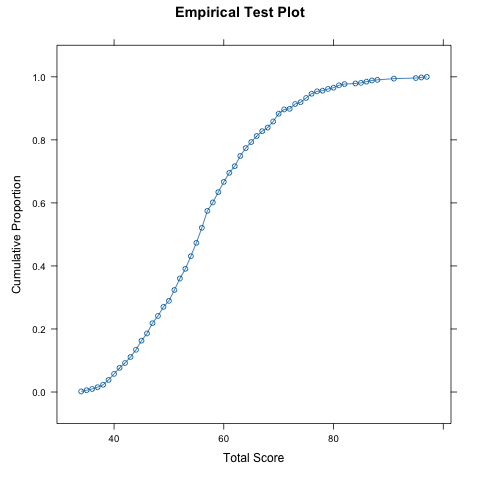

In [50]:
%%R

empirical_plot(data_df_spread)